In [1]:
LOAD_FROM_CACHE = False

In [2]:
from pytorch_transformers import GPT2Tokenizer
from experiment import Intervention, Model
from attention_utils import perform_interventions, report_intervention, report_interventions_summary
import pandas as pd
import json

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = Model(output_attentions=True)

In [4]:
# Test experiment
interventions = [
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["asked", "answered"]),
	Intervention(
        tokenizer,
        "The doctor asked the nurse a question. {}",
        ["He", "She"],
        ["requested", "responded"]),
	Intervention(
        tokenizer,
        "The man felt sorry about what he said to the woman. {}",
        ["He", "She"],
        ["apologized", "forgave"]),
	Intervention(
        tokenizer,
        "The nurse notified the patient that {}",
        ["her", "his"],
        ["shift", "blood"])
]

fname = 'test_attn_int.json'
if not LOAD_FROM_CACHE:
	results = perform_interventions(interventions, model)
	with open(fname, 'w') as f:
		json.dump(results, f)
with open(fname) as f:
	results = json.load(f)


100%|██████████| 4/4 [01:15<00:00, 18.79s/it]


x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: asked
c2: answered

p(c2|x) / p(c1|x) = 0.06125
p(c2|x') / p(c1|x') = 0.37261

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) = 6.084


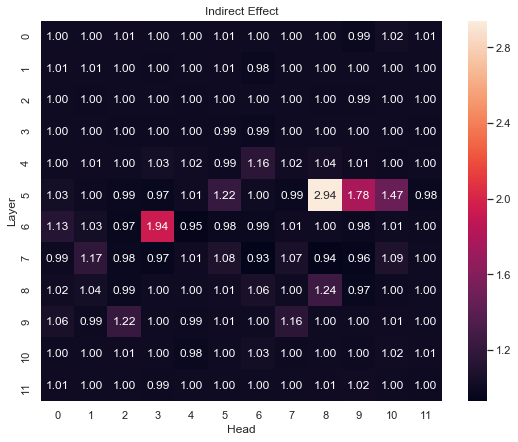

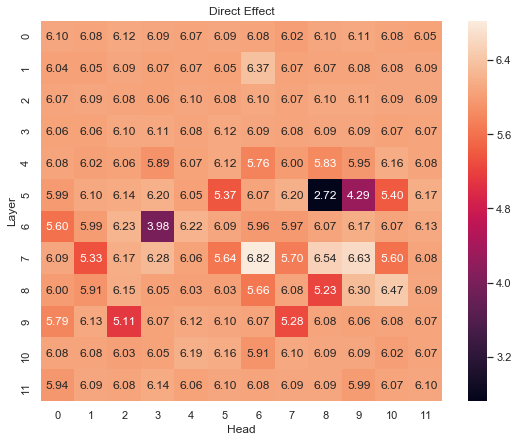

In [5]:
report_intervention(results[0])

x : The doctor asked the nurse a question. He
x': The doctor asked the nurse a question. She
c1: requested
c2: responded

p(c2|x) / p(c1|x) = 5.60562
p(c2|x') / p(c1|x') = 48.40155

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) = 8.634


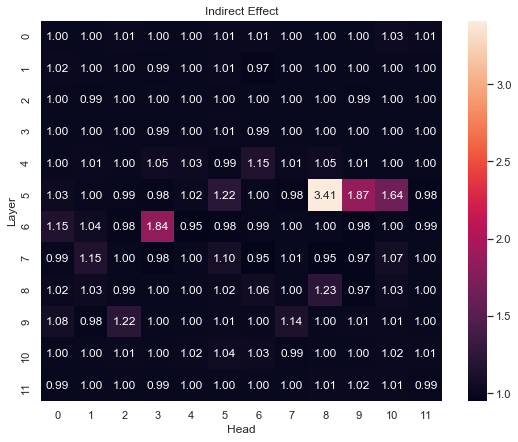

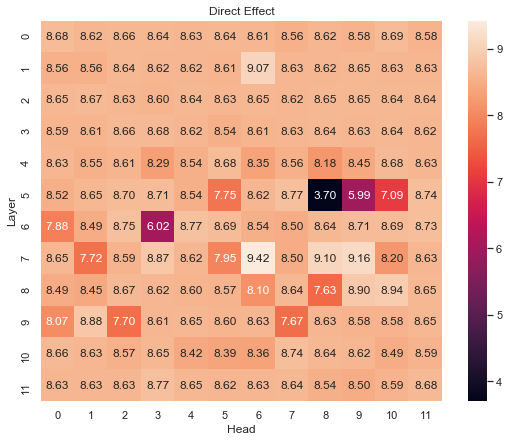

In [6]:
report_intervention(results[1])

x : The man felt sorry about what he said to the woman. He
x': The man felt sorry about what he said to the woman. She
c1: apologized
c2: forg ave

p(c2|x) / p(c1|x) = 1.22404
p(c2|x') / p(c1|x') = 3.17622

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) = 2.595


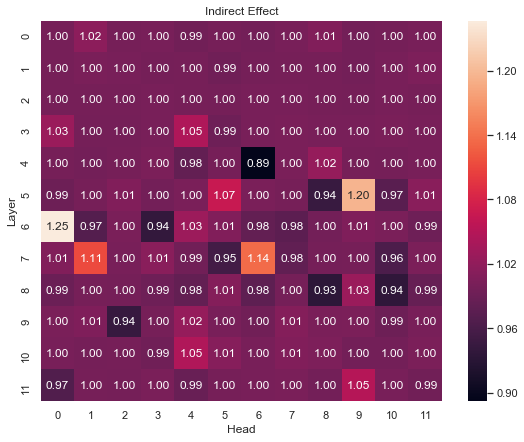

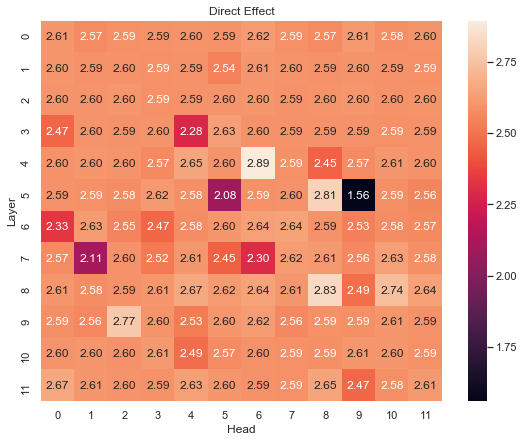

In [7]:
report_intervention(results[2])

x : The nurse notified the patient that her
x': The nurse notified the patient that his
c1: shift
c2: blood

p(c2|x) / p(c1|x) = 41.54527
p(c2|x') / p(c1|x') = 102.70793

TOTAL Effect: (p(c2|x') / p(c1|x')) / (p(c2|x) / p(c1|x)) = 2.472


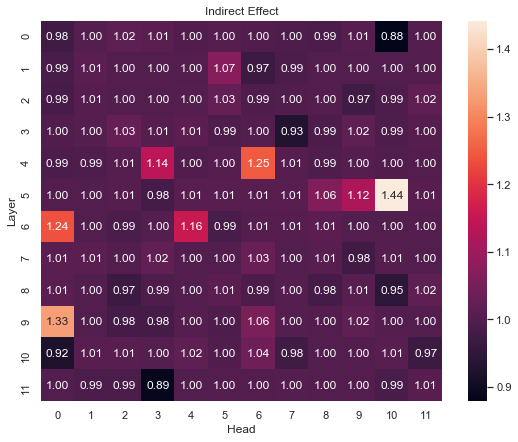

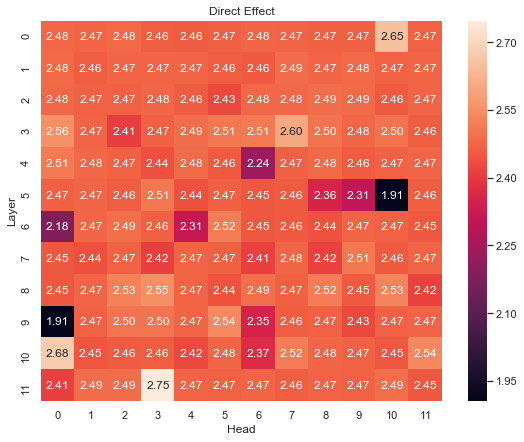

In [8]:
report_intervention(results[3])

*** SUMMARY ***
Num interventions: 4
Mean total effect: 4.95


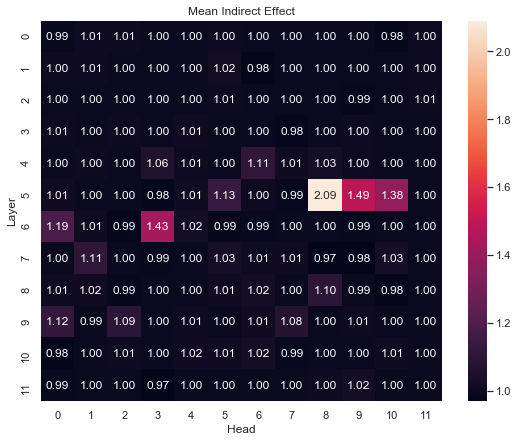

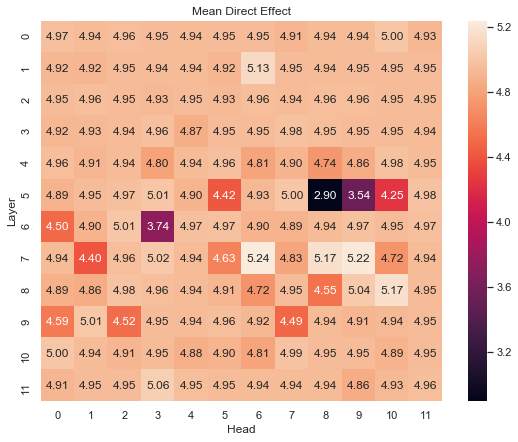

In [9]:
report_interventions_summary(results)
